In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
POS_COLOR, NEG_COLOR, NEU_COLOR = '#38C477','#F2543D','#EEEEEE'
STOP_WORDS = set(stopwords.words('english'))

### Data

In [3]:
# Read the data
train_df = pd.read_csv("Corona_NLP_train.csv", encoding='latin1')
test_df = pd.read_csv("Corona_NLP_test.csv", encoding='latin1')

train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
train_df.dtypes

UserName          int64
ScreenName        int64
Location         object
TweetAt          object
OriginalTweet    object
Sentiment        object
dtype: object

In [5]:
train_df['OriginalTweet'] = train_df['OriginalTweet'].astype(str)
train_df['Sentiment'] = train_df['Sentiment'].astype(str)

test_df['OriginalTweet'] = test_df['OriginalTweet'].astype(str)
test_df['Sentiment'] = test_df['Sentiment'].astype(str)

# Remove unwanted columns
remove_cols = ['UserName', 'ScreenName', 'Location', 'TweetAt']
train_df.drop(remove_cols, axis=1, inplace=True)
test_df.drop(remove_cols, axis=1, inplace=True)

train_df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [6]:
print('Number of rows in training: {}'.format(train_df.shape[0]))
print('Number of rows in test: {}'.format(test_df.shape[0]))

Number of rows in training: 41157
Number of rows in test: 3798


In [7]:
# Label values
train_df.Sentiment.unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

In [8]:
# Combine positive and extermely positive classes, and negative and extremely negative classes
def combine_classes(x):
    if x in ["Extremely Positive", "Positive"]:
        return "Positive"
    elif x in ["Extremely Negative", "Negative"]:
        return "Negative"
    else:
        return "Neutral"
    
train_df['Sentiment'] = train_df['Sentiment'].apply(lambda x:combine_classes(x))
test_df['Sentiment'] = test_df['Sentiment'].apply(lambda x:combine_classes(x))

In [9]:
train_df.Sentiment.unique()

array(['Neutral', 'Positive', 'Negative'], dtype=object)

Text(0.5, 1.0, 'Test Label Distribution')

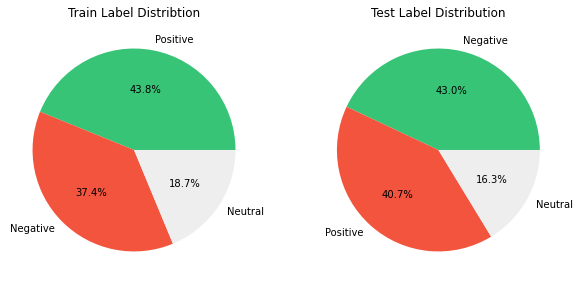

In [10]:
train_label_counts = train_df['Sentiment'].value_counts().to_dict()
test_label_counts = test_df['Sentiment'].value_counts().to_dict()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10)) 

ax1.pie(train_label_counts.values(), labels=train_label_counts.keys(), colors = [POS_COLOR, NEG_COLOR, NEU_COLOR], autopct = '%1.1f%%')
ax1.set_title('Train Label Distribtion')

ax2.pie(test_label_counts.values(), labels = test_label_counts.keys(), colors = [POS_COLOR, NEG_COLOR, NEU_COLOR], autopct = '%1.1f%%')
ax2.set_title('Test Label Distribution')

In [11]:
def preprocessing(text):
    text = text.lower()
    
    # Remove URLs and HTML links
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove punctuations
    text = re.sub(r"[^\w\s\d]","", text)
    
    # Remove mentions
    text = re.sub(r'@\w+','', text)
    
    # Remove hashtags
    text = re.sub(r'#\w+','', text)
    
    # Remove whitepsaces
    text = re.sub(r"\s+"," ",text).strip()
    
    # Stemming
    my_tokens = text.split()
    porter = PorterStemmer()
    stemmed_tokens = []
    for token in my_tokens:
        if len(token) > 2:
            stemmed_tokens.append(porter.stem(token))

    text = " ".join(stemmed_tokens)
    
    # Remove stopwords
    text = text.split()
    text = " ".join([word for word in text if not word in STOP_WORDS])
    
    return text

train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: preprocessing(x))

In [12]:
train_df['Count'] = train_df['OriginalTweet'].str.split().str.len()
max_len = round(train_df['Count'].mean())
print("Average Tweet Length: ", max_len)

Average Tweet Length:  18


In [13]:
pos_df = train_df[train_df["Sentiment"] == "Positive"]
neg_df = train_df[train_df["Sentiment"] == "Negative"]
neu_df = train_df[train_df["Sentiment"] == "Neutral"]

pos_df['Count'] = pos_df['OriginalTweet'].str.split().str.len()
neg_df['Count'] = neg_df['OriginalTweet'].str.split().str.len()
neu_df['Count'] = neu_df['OriginalTweet'].str.split().str.len()

pos_count, neg_count, neu_count = pos_df['Count'].mean(), neg_df['Count'].mean(), neu_df['Count'].mean()

<ipython-input-13-f76a34e7a913>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_df['Count'] = pos_df['OriginalTweet'].str.split().str.len()
<ipython-input-13-f76a34e7a913>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_df['Count'] = neg_df['OriginalTweet'].str.split().str.len()
<ipython-input-13-f76a34e7a913>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

<BarContainer object of 3 artists>

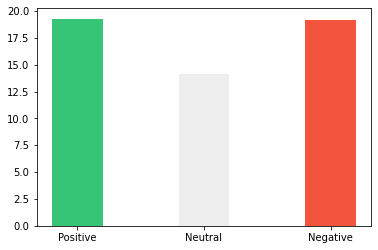

In [34]:
# Average number of words in a tweet for each class
plt.bar(['Positive', 'Neutral', 'Negative'], [pos_count, neu_count, neg_count], color = [POS_COLOR, NEU_COLOR, NEG_COLOR],
        width = 0.4)

In [15]:
pos_wc = WordCloud(background_color="white", colormap="Greens").generate(' '.join(pos_df['OriginalTweet']))
neg_wc = WordCloud(background_color="white", colormap="Reds").generate(' '.join(neg_df['OriginalTweet']))
neu_wc = WordCloud(background_color="white", colormap="Greys").generate(' '.join(neu_df['OriginalTweet']))

Text(0.5, 1.0, 'Negative')

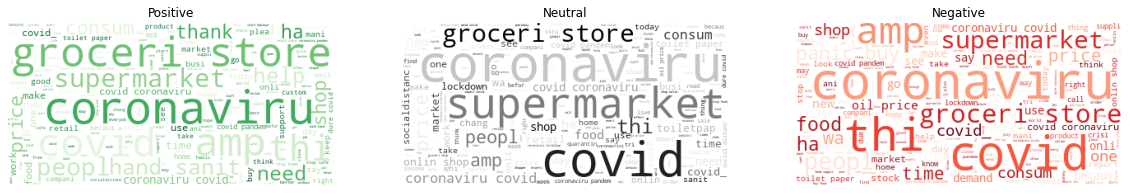

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,20)) 

ax1.imshow(pos_wc)
ax1.axis("off")
ax1.set_title("Positive")

ax2.imshow(neu_wc)
ax2.axis("off")
ax2.set_title("Neutral")

ax3.imshow(neg_wc)
ax3.axis("off")
ax3.set_title("Negative")

In [17]:
import numpy as np

In [18]:
label_dict = {"Positive": 0, "Neutral": 1, "Negative": 2}
train_df['Sentiment'] = train_df['Sentiment'].map(label_dict)
test_df['Sentiment']  = test_df['Sentiment'].map(label_dict)

X_train, Y_train = train_df["OriginalTweet"], train_df["Sentiment"]
X_test, Y_test = test_df["OriginalTweet"], test_df["Sentiment"]

In [19]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

y_train = to_categorical(Y_train, 3)
y_test = to_categorical(Y_test, 3)

In [20]:
max_len = 30
tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_train)
vocab_length = len(tokenizer.word_index) + 1

x_train = tokenizer.texts_to_sequences(X_train)
x_test = tokenizer.texts_to_sequences(X_test)

x_train = pad_sequences(x_train, maxlen=max_len, padding='post')
x_test = pad_sequences(x_test, maxlen=max_len, padding='post')

In [21]:
print(vocab_length, max_len)

48464 30


### CNN

In [31]:
from keras.layers import Conv1D, MaxPooling1D, Flatten, BatchNormalization, Activation

model = Sequential()
model.add(Embedding(vocab_length, embedding_dim, input_length=max_len))
model.add(Conv1D(filters=64, kernel_size=3, padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(3))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer="adam", loss = 'categorical_crossentropy', metrics = ['accuracy'])

print(model.summary())

plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

model.fit(x_train, y_train,
          batch_size = 32,
          epochs = 2,
          validation_split=0.2)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 30, 32)            1550848   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 30, 64)            6208      
_________________________________________________________________
batch_normalization_5 (Batch (None, 30, 64)            256       
_________________________________________________________________
activation_5 (Activation)    (None, 30, 64)            0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 10, 64)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 640)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 640)              

In [32]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
30/30 [==============================] - 0s 3ms/step - loss: 1.0256 - accuracy: 0.5948
test loss, test acc: [1.0255564451217651, 0.5947867035865784]


### LSTM

In [33]:
from keras.layers import Embedding, LSTM, Dense, Dropout, GlobalAveragePooling1D
from keras.models import Sequential
from keras import optimizers
from keras.utils.vis_utils import plot_model

embedding_dim = 32

model = Sequential()
model.add(Embedding(vocab_length,embedding_dim, input_length=max_len))
model.add(LSTM(64,return_sequences=True, dropout=0.5))
model.add(GlobalAveragePooling1D())
model.add(Dense(64))
model.add(Dense(3,activation='softmax'))

model.compile(optimizer="adam", loss = 'categorical_crossentropy', metrics = ['accuracy'])

print(model.summary())

plot_model(model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)

model.fit(x_train, y_train,
          batch_size = 32,
          epochs = 2,
          validation_split=0.2)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 30, 32)            1550848   
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 64)            24832     
_________________________________________________________________
global_average_pooling1d_3 ( (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 195       
Total params: 1,580,035
Trainable params: 1,580,035
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
1029/1029 [==============================] - 14s 13ms/step - loss: 0.7384 - accuracy: 0.6712 - 

In [30]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
30/30 [==============================] - 0s 3ms/step - loss: 0.9700 - accuracy: 0.6156
test loss, test acc: [0.9700031876564026, 0.6155871748924255]
